In [1]:
from orange_peels import OrangePeelsDataset
from orange_peels import Constants as c
import utils
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import json

# Testing on New Data
This file tests an existing model on new data (i.e., images taken with new settings).

In [25]:
device = utils.get_device()

Device: cuda:0


In [33]:
# load model
model = torch.load("resnet50_full_no_kfold_white_red.pt").to(device)
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [34]:
# source = "./data_orange_peels_rand/"
source = "./data_orange_peels_white_red"
for subdir in os.listdir(source):
    length = len([f for f in os.listdir(os.path.join(source, subdir)) if f.startswith("IMG")])
    print(f"Class {subdir}: {length}")

Class 10: 187
Class 15: 143
Class 20: 231
Class 6: 136


In [35]:
transform = transforms.Compose([
    transforms.Resize((int(c.IMG_SIZE[0]*c.IMG_MAG), int(c.IMG_SIZE[1]*c.IMG_MAG))),
    transforms.Normalize(mean=c.RESNET_MEAN, std=c.RESNET_STD)
])

inv_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in c.RESNET_STD]),
    transforms.Normalize(mean = [-m for m in c.RESNET_MEAN], std = [1., 1., 1.]),
    # transforms.ColorJitter(contrast=1/0.01),
])

In [36]:
data_random = OrangePeelsDataset(source, class_size=30, transform=transform, stats=True)
loader = DataLoader(data_random, batch_size=10, shuffle=True)

Class: 10	Available: 187		Added: 30
Class: 15	Available: 143		Added: 30
Class: 20	Available: 231		Added: 30
Class: 6	Available: 136		Added: 30
		Total: 697		Total: 120


In [37]:
# make predictions with model
pred = torch.tensor([], dtype=torch.long).to(device)
true = torch.tensor([], dtype=torch.long).to(device)
with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred = torch.cat((pred, predicted))
        true = torch.cat((true, labels))
pred = pred.cpu().numpy()
true = true.cpu().numpy()

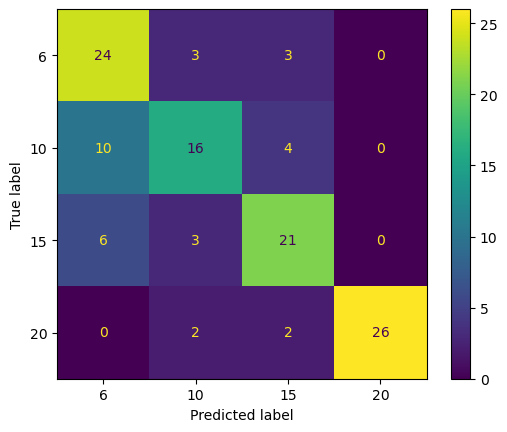

In [38]:
# calculate accuracy
cm, report = utils.generate_metrics(true, pred)

In [39]:
# find most common predicted
np.unique(pred, return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([40, 24, 30, 26], dtype=int64))

In [40]:
print(json.dumps(report, indent=4))

{
    "0": {
        "precision": 0.6,
        "recall": 0.8,
        "f1-score": 0.6857142857142857,
        "support": 30
    },
    "1": {
        "precision": 0.6666666666666666,
        "recall": 0.5333333333333333,
        "f1-score": 0.5925925925925926,
        "support": 30
    },
    "2": {
        "precision": 0.7,
        "recall": 0.7,
        "f1-score": 0.7,
        "support": 30
    },
    "3": {
        "precision": 1.0,
        "recall": 0.8666666666666667,
        "f1-score": 0.9285714285714286,
        "support": 30
    },
    "accuracy": 0.725,
    "macro avg": {
        "precision": 0.7416666666666667,
        "recall": 0.725,
        "f1-score": 0.7267195767195767,
        "support": 120
    },
    "weighted avg": {
        "precision": 0.7416666666666667,
        "recall": 0.725,
        "f1-score": 0.7267195767195768,
        "support": 120
    }
}
